In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import loader
import plot
import helpers
import importlib
importlib.reload(loader)
importlib.reload(plot)
importlib.reload(helpers)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split, StratifiedKFold, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import RMSprop
from sklearn.ensemble import AdaBoostClassifier

In [2]:
data = loader.load_cancer_data()

In [3]:
data.head()

,radius mean,texture mean,perimeter mean,area mean,smoothness mean,compactness mean,concavity mean,concave points mean,symmetry mean,fractal dimension mean,...,texture worst,perimeter worst,area worst,smoothness worst,compactness worst,concavity worst,concave points worst,symmetry worst,fractal dimension worst,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [4]:
features = [col for col in data.columns if col != "target"]
X = data[features]
y = data["target"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [6]:
basic = DecisionTreeClassifier()
path = basic.cost_complexity_pruning_path(X_train, y_train)

In [7]:
path.ccp_alphas

array([0.        , 0.00249353, 0.00250183, 0.00491206, 0.00496107,
       0.00603015, 0.0080402 , 0.00860731, 0.00948431, 0.02928727,
       0.03072074, 0.34564179])

In [8]:
basic = DecisionTreeClassifier()
basic.fit(X_train, y_train)

DecisionTreeClassifier()

In [9]:
basic.tree_.max_depth

6

In [10]:
basic.tree_.node_count

29

In [11]:
# Decision Tree
basic_param_grid=dict(criterion=['gini'])
clf = DecisionTreeClassifier()
basic_grid = GridSearchCV(estimator=clf, param_grid=basic_param_grid, return_train_score=True)
basic_grid_result = basic_grid.fit(X_train, y_train)
basic_res = basic_grid_result.cv_results_
basic_res_df = helpers.scikit_cv_result_to_df(basic_res)
basic_res_df.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
criterion,,,,,,,,,
gini,0.010288,0.000848,0.003539,0.00017,0.917057,0.01728,1,1.0,0.0


In [12]:
basic_res_df[helpers.get_useful_cv_columns()]

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
criterion,,,,
gini,0.010288,0.003539,0.917057,1.0


In [13]:
basic = DecisionTreeClassifier()
criterion = ['gini', 'entropy']
ccp_alpha = path.ccp_alphas

param_grid = dict(criterion=criterion, ccp_alpha=ccp_alpha)
grid = GridSearchCV(estimator=basic, param_grid=param_grid, return_train_score=True)
grid_result = grid.fit(X_train, y_train)

In [14]:
res = grid_result.cv_results_
res

{'mean_fit_time': array([0.01036296, 0.01005011, 0.01003432, 0.01032982, 0.00997148,
        0.01042652, 0.00992713, 0.0101778 , 0.00998521, 0.01043477,
        0.01012902, 0.01017141, 0.00984154, 0.0102212 , 0.00987206,
        0.01011977, 0.00980239, 0.01028724, 0.00983815, 0.01008792,
        0.01004014, 0.01032581, 0.00991859, 0.01015739]),
 'std_fit_time': array([0.00081415, 0.00035023, 0.00067618, 0.00046167, 0.00077569,
        0.00023794, 0.00056764, 0.0003426 , 0.00071954, 0.00029925,
        0.00075298, 0.00029034, 0.00076135, 0.00033104, 0.00071711,
        0.00038741, 0.00077625, 0.00029546, 0.00073394, 0.00026033,
        0.00097087, 0.00035586, 0.00066327, 0.00037462]),
 'mean_score_time': array([0.0034482 , 0.00337176, 0.00324721, 0.00329928, 0.00317998,
        0.00332789, 0.00317888, 0.00326562, 0.00323763, 0.00325999,
        0.00351563, 0.00319843, 0.00312562, 0.0032351 , 0.00336018,
        0.00319576, 0.00333376, 0.00325613, 0.00321331, 0.00314174,
        0.003257

In [15]:
res_df = helpers.scikit_cv_result_to_df(res)
res_df.sort_values(by='rank_test_score')

,,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
ccp_alpha,criterion,,,,,,,,,
0.006030,entropy,0.010171,0.000290,0.003198,0.000139,0.947152,0.035263,1,1.000000,0.000000
0.008607,entropy,0.010120,0.000387,0.003196,0.000107,0.947120,0.034375,2,1.000000,0.000000
0.004912,entropy,0.010178,0.000343,0.003266,0.000154,0.944620,0.033612,3,1.000000,0.000000
0.002494,entropy,0.010330,0.000462,0.003299,0.000145,0.942152,0.030504,4,1.000000,0.000000
0.008040,entropy,0.010221,0.000331,0.003235,0.000045,0.942152,0.026086,4,1.000000,0.000000
0.004961,entropy,0.010435,0.000299,0.003260,0.000163,0.939652,0.026877,6,1.000000,0.000000
0.002502,entropy,0.010427,0.000238,0.003328,0.000113,0.939589,0.033394,7,1.000000,0.000000
0.029287,entropy,0.010088,0.000260,0.003142,0.000100,0.934684,0.018505,8,0.976128,0.009647
0.009484,entropy,0.010287,0.000295,0.003256,0.000101,0.934620,0.031252,9,0.998742,0.001541


In [23]:
res_df.sort_values(by='ccp_alpha')[helpers.get_useful_cv_columns()]

mean_fit_time  mean_score_time  mean_test_score  \
ccp_alpha criterion                                                    
0.000000  gini            0.010363         0.003448         0.919525   
          entropy         0.010050         0.003372         0.934589   
0.002494  gini            0.010034         0.003247         0.924525   
          entropy         0.010330         0.003299         0.942152   
0.002502  gini            0.009971         0.003180         0.924589   
          entropy         0.010427         0.003328         0.939589   
0.004912  gini            0.009927         0.003179         0.924494   
          entropy         0.010178         0.003266         0.944620   
0.004961  gini            0.009985         0.003238         0.914462   
          entropy         0.010435         0.003260         0.939652   
0.006030  entropy         0.010171         0.003198         0.947152   
          gini            0.010129         0.003516         0.929620   
0.008040  gini            0.009842         0.003126         0.919525   
          entropy         0.010221         0.003235         0.942152   
0.008607  gini            0.009872         0.003360         0.919525   
          entropy         0.010120         0.003196         0.947120   
0.009484  gini            0.009802         0.003334         0.917025   
          entropy         0.010287         0.003256         0.934620   
0.029287  gini            0.009838         0.003213         0.917057   
          entropy         0.010088         0.003142         0.934684   
0.030721  gini            0.010040         0.003257         0.922120   
          entropy         0.010326         0.003316         0.927089   
0.345642  gini            0.009919         0.003174         0.731234   
          entropy         0.010157         0.003190         0.909430   

                     mean_train_score  
ccp_alpha criterion                    
0.000000  gini               1.000000  
          entropy            1.000000  
0.002494  gini               1.000000  
          entropy            1.000000  
0.002502  gini               1.000000  
          entropy            1.000000  
0.004912  gini               0.992461  
          entropy            1.000000  
0.004961  gini               0.992461  
          entropy            1.000000  
0.006030  entropy            1.000000  
          gini               0.990576  
0.008040  gini               0.983033  
          entropy            1.000000  
0.008607  gini               0.983033  
          entropy            1.000000  
0.009484  gini               0.979259  
          entropy            0.998742  
0.029287  gini               0.956024  
          entropy            0.976128  
0.030721  gini               0.954770  
          entropy            0.971740  
0.345642  gini               0.755610  
          entropy            0.933418

In [17]:
gini = res_df.xs('gini', level='criterion')
entropy = res_df.xs('entropy', level='criterion')

In [27]:
gini

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
ccp_alpha,,,,,,,,,
0.000000,0.010363,0.000814,0.003448,0.000190,0.919525,0.017449,17,1.000000,0.000000
0.002494,0.010034,0.000676,0.003247,0.000144,0.924525,0.026751,14,1.000000,0.000000
0.002502,0.009971,0.000776,0.003180,0.000161,0.924589,0.008264,13,1.000000,0.000000
0.004912,0.009927,0.000568,0.003179,0.000074,0.924494,0.022963,15,0.992461,0.003210
0.004961,0.009985,0.000720,0.003238,0.000173,0.914462,0.023492,22,0.992461,0.003210
0.006030,0.010129,0.000753,0.003516,0.000185,0.929620,0.020564,11,0.990576,0.003448
0.008040,0.009842,0.000761,0.003126,0.000088,0.919525,0.015453,17,0.983033,0.005846
0.008607,0.009872,0.000717,0.003360,0.000091,0.919525,0.015453,17,0.983033,0.005846
0.009484,0.009802,0.000776,0.003334,0.000238,0.917025,0.013188,21,0.979259,0.008593


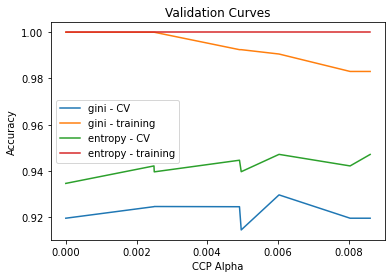

In [19]:
plt.plot(path.ccp_alphas[:8], gini['mean_test_score'].iloc[:8], label='gini - CV')
plt.plot(path.ccp_alphas[:8], gini['mean_train_score'].iloc[:8],  label='gini - training')
plt.plot(path.ccp_alphas[:8], entropy['mean_test_score'].iloc[:8], label='entropy - CV')
plt.plot(path.ccp_alphas[:8], entropy['mean_train_score'].iloc[:8], label='entropy - training')
plt.legend(loc='best')
plt.title('Validation Curves')
plt.ylabel('Accuracy')
plt.xlabel('CCP Alpha')
plt.show()

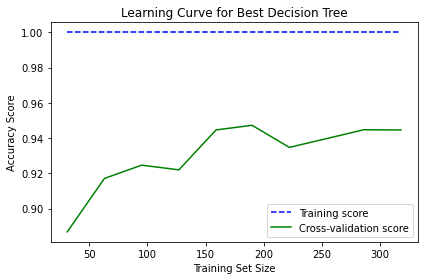

In [21]:
best_model = DecisionTreeClassifier(criterion='entropy', ccp_alpha=.006030)
plot.plot_learning_curve(best_model, X_train, y_train, title='Learning Curve for Best Decision Tree')

In [29]:
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)
print(f"Final accuracy achieved: {accuracy_score(y_test, y_test_pred)}")

Final accuracy achieved: 0.935672514619883


In [24]:
best_model.get_n_leaves()

14

In [25]:
best_model.tree_.node_count

27

In [26]:
best_model.tree_.max_depth

5